<a href="https://colab.research.google.com/github/NMashalov/2023_OpenMipt_course/blob/main/lesson9/pca_sem2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsOneClassifier

sns.set(palette='Set2', font_scale=1.4)

## Cнижение размерностей



---
### Задача 1

В этой задаче мы попробуем применить PCA-разложение для уменьшения размерности данных в задаче классификации. Во многих случаях такая процедура позволяет выделить значимую информацию из датасета при незначительных потерях качества. А в лучшем случае мы избавимся от шумовых признаков и увеличим результат.

Будем использовать простой датасет для задачи классификации вин трех разных видов. На практике вам могут встретиться намного более объемные данные, которые имеют большую размерность (представьте, например, что вы закодировали большое число категориальных признаков с помощью one-hot).

Загрузим данные:

In [29]:
data = load_wine()
X, y = data['data'], data['target']

Посмотрим на описание:

In [30]:
print(data['DESCR'])

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

    :Number of Instances: 178
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- Alcohol
 		- Malic acid
 		- Ash
		- Alcalinity of ash  
 		- Magnesium
		- Total phenols
 		- Flavanoids
 		- Nonflavanoid phenols
 		- Proanthocyanins
		- Color intensity
 		- Hue
 		- OD280/OD315 of diluted wines
 		- Proline

    - class:
            - class_0
            - class_1
            - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash:            10.6  30.0    19.5   3.3
    Ma

Разделим данные на обучающую и тестовую выборки.

Для того, чтобы сохранить пропорции каждого класса, используем аргумент `stratify`.

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

Выполните стандартизацию данных. Объясните, почему она необходима в этом случае.

**Ответ:** метод линейный. Будет выбирать направления с большой дисперсией. В данном случае большая дисперсия может быть связана с масштабом выборки

In [78]:
mean, std = X_train.mean(axis=0),X_train.std(axis=0)
X_train, X_test = (X_train - mean)/ std,(X_test - mean)/ std

Визуализируйте проекцию выборки на первые две компоненты. Являются ли классы линейно разделимыми?

In [80]:
low_dim = PCA(n_components=1).fit_transform(X_train)

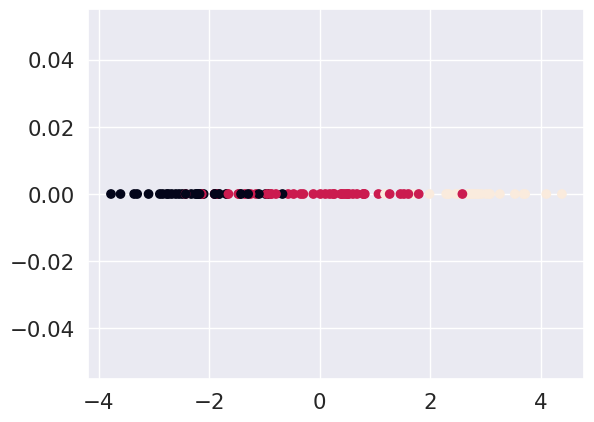

In [81]:
plt.scatter(x=low_dim,y=np.zeros_like(low_dim),c=y_train)

In [67]:
low_dim = PCA(n_components=2).fit_transform(X_train)

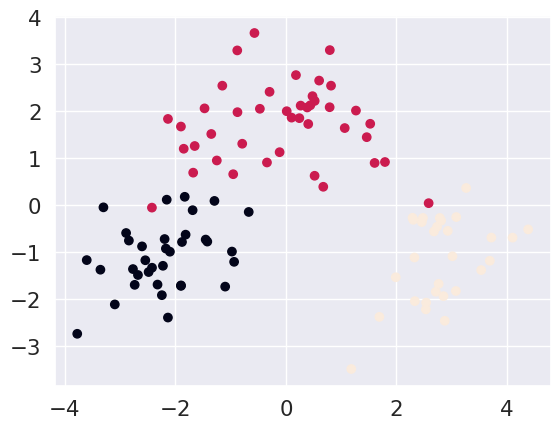

In [68]:
plt.scatter(x=low_dim[:,0],y=low_dim[:,1],c=y_train)

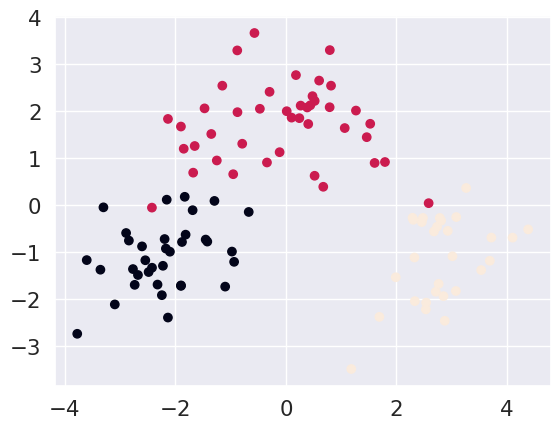

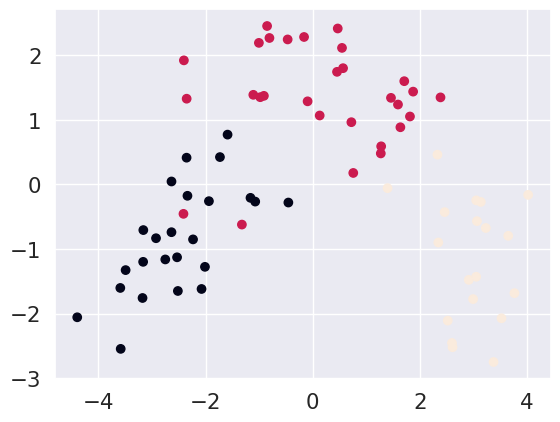

In [82]:
p = PCA(n_components=2).fit(X_train)
c_train, c_test = p.transform(X_train), p.transform(X_test)

plt.scatter(x=c_train[:,0],y=c_train[:,1],c=y_train)
plt.show()
plt.scatter(x=c_test[:,0],y=c_test[:,1],c=y_test)
plt.show()

**Ответ:** классы визуально линейно разделимы

Постройте график зависимости качества логистической регрессии на тестовой выборке от числа компонент. Что можно наблюдать?

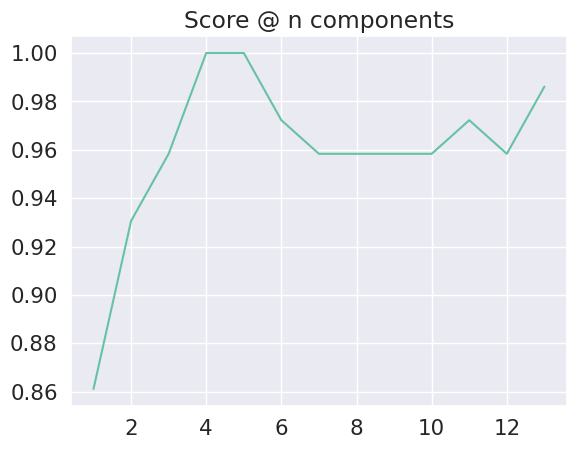

In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

scores = []
r = range(1,X_train.shape[1]+1)
for i in r:
    pipe = Pipeline([('PCA', PCA(n_components=i)), ('LR', LogisticRegression())])
    scores.append(pipe.fit(X_train,y_train).score(X_test,y_test))

plt.title('Score @ n components')
plt.plot(r,scores)


**Ответ:** лучшее качество предсказания получаем для 4 компоеннент. Связываю это с наиболее удачным линейным представлением

Для лучшей комбинации компонент попробуйте логистическую регрессию с различными стратегиями многоклассовой классификации: `multinomial`, `OvO`, `OvR`. Как можно объяснить результаты?

In [91]:
strategy = ['multinomial', 'ovr']

[Pipeline([('PCA', PCA(n_components=4)), ('LR', LogisticRegression(multi_class = strat))]).fit(X_train,y_train).score(X_test,y_test) for strat in strategy]

[1.0, 1.0]

Классы линейно разделимы не только попарно, но и от всех прочих элементов

Попробуйте обучить обычную логистическую регрессию с Lasso-регуляризацией и выделить самые важные признаки. В чем отличие такого подхода от использования PCA-разложения?

In [98]:
l = LogisticRegression(penalty='l1',solver='saga',multi_class='multinomial').fit(X_train,y_train)
print('feature_importance', l.coef_)
print('score', l.score(X_test,y_test))

feature_importance [[ 0.          0.          0.         -0.15831821  0.          0.
   0.51560714  0.          0.          0.          0.          0.41056569
   1.55599716]
 [-1.5056098  -0.1505475  -0.76956695  0.          0.          0.
   0.          0.          0.15741098 -1.16559323  0.2800219   0.
  -0.82228341]
 [ 0.          0.          0.          0.          0.          0.
  -1.67656844  0.         -0.21237658  0.16278701 -0.96657939 -0.23623229
   0.        ]]
score 0.9722222222222222


**Ответ:** Качество классификации различается незначительно. Разложение по PCA подбирает пространство, в котором оптимизационная задача значительно упрощается

Какие есть преимущества и недостатки у снижения размерности перед обучением классификатора? Сделайте выводы по задаче.

**Вывод:**

Минусы:
- не всегда задачи классификации объясняется наибольшим источником дисперсии. Информативной может быть компонента с большим порядковым номером
- pca линейная модель.Чувствительна к выбросам. Плохо работает с кластерами - сгустками плотностей. Для таких данных лучше подходят методы основанные на расчете плотностей

Плюсы:
- понижение размерности позволяет визуально предварительно проверить разделимость классов
- пространство малой размерности интепретируемо, не подвержено проклятию размерности
- понижеие размерности одна из форм регуляризации. Позволяет улучшать качество классификации с широким предварительно необратанным признаковым пространством и малым числом сэмплов